In [ ]:
"""
This is to build a visual understanding of the relationship between reconstruction loss
and the number of tokens used to achieve that loss without taking the image itself into consideration.
It is expected for the loss to decrease as the number of tokens increases.
However, we hypothesize that the image itself also plays a role in determining the needed token count,
meaning that different images may require different numbers of tokens to achieve similar levels of 
reconstruction quality.
"""

In [ ]:
import json
import os
# add the parent directory to the Python path
import sys
sys.path.append(os.path.abspath(".."))   # one level up from notebook/
print(sys.path)
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict


['/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python311.zip', '/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11', '/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/lib-dynload', '', '/BS/data_mani_compress/work/miniforge3/envs/dgm_geometry/lib/python3.11/site-packages', '/BS/data_mani_compress/work/thesis/thesis/external/guided-diffusion', '/BS/data_mani_compress/work/thesis/thesis/external/DenseFlow', '/BS/data_mani_compress/work/thesis/thesis', '/BS/data_mani_compress/work/thesis/thesis', '/BS/data_mani_compress/work/thesis/thesis']


In [7]:
with open(('../data/datasets/reconstruction_loss_imgnet_train/reconstruction_errors_all.json'), 'r') as f:
    data = json.load(f)

In [ ]:
# pick a small range for reconstruction loss to visualize
loss_range = (2.83, 2.830001)
filtered_data = [(entry['k_value'], entry['vgg_error'], entry['image_id']) for entry in data 
                 if loss_range[0] <= entry['vgg_error'] <= loss_range[1]]
print(len(filtered_data))
print(filtered_data)

In [30]:
# find the average token_count
average_token_count = sum(entry["k_value"] for entry in data) / len(data) 
print(average_token_count)

69.1


[{'image_id': 99, 'k_value': 1, 'mse_error': 0.2929057776927948, 'vgg_error': 4.103018283843994}, {'image_id': 99, 'k_value': 2, 'mse_error': 0.3433198630809784, 'vgg_error': 4.244497776031494}, {'image_id': 99, 'k_value': 4, 'mse_error': 0.3309490978717804, 'vgg_error': 4.325486660003662}, {'image_id': 99, 'k_value': 8, 'mse_error': 0.2950533628463745, 'vgg_error': 4.516955375671387}, {'image_id': 99, 'k_value': 16, 'mse_error': 0.28461334109306335, 'vgg_error': 4.574591159820557}, {'image_id': 99, 'k_value': 32, 'mse_error': 0.26491111516952515, 'vgg_error': 4.626087188720703}, {'image_id': 99, 'k_value': 64, 'mse_error': 0.26781198382377625, 'vgg_error': 4.610061168670654}, {'image_id': 99, 'k_value': 128, 'mse_error': 0.2085614800453186, 'vgg_error': 4.247549057006836}, {'image_id': 99, 'k_value': 180, 'mse_error': 0.1785125583410263, 'vgg_error': 3.910229206085205}, {'image_id': 99, 'k_value': 256, 'mse_error': 0.1578739434480667, 'vgg_error': 3.529815435409546}]


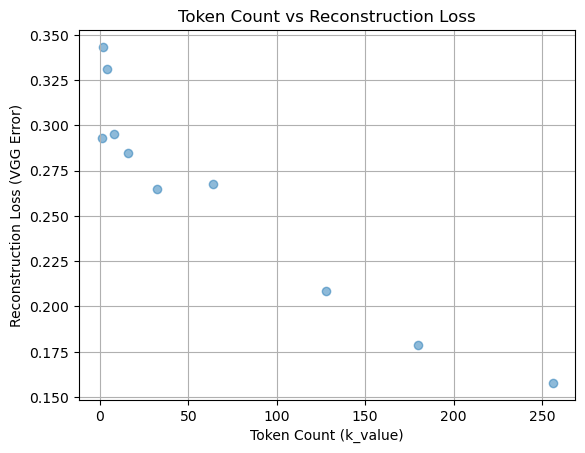

In [52]:
# check token count and reconstruction loss relation with a single image
first_images = [datum for datum in data if datum["image_id"] == 99]
print(first_images)

# plot the relationship between token count and reconstruction loss
k_values = [entry['k_value'] for entry in first_images]
vgg_errors = [entry['mse_error'] for entry in first_images]
plt.scatter(k_values, vgg_errors, alpha=0.5)
plt.xlabel('Token Count (k_value)')
plt.ylabel('Reconstruction Loss (VGG Error)')
plt.title('Token Count vs Reconstruction Loss')
plt.grid(True)
plt.show()

In [60]:
# Aggregate trend: mean/median loss per token count to reveal overall inverse relationship

# Build arrays
k_vals = np.array([int(d["k_value"]) for d in data])
loss_vals = np.array([float(d["mse_error"]) for d in data])

# Group losses by k
by_k = defaultdict(list)
for k, l in zip(k_vals, loss_vals):
    by_k[int(k)].append(float(l))

ks = sorted(by_k.keys())
mean_loss = np.array([np.mean(by_k[k]) for k in ks])
median_loss = np.array([np.median(by_k[k]) for k in ks])
std_loss = np.array([np.std(by_k[k]) for k in ks])
# 95% CI (approx) if you want: 1.96 * std/sqrt(n)
ci95 = np.array([1.96 * (np.std(by_k[k]) / max(1, np.sqrt(len(by_k[k])))) for k in ks])

print("Unique k values:", ks)
print("Mean loss per k (first 10):", list(zip(ks, mean_loss))[:10])

Unique k values: [1, 2, 4, 8, 16, 32, 64, 128, 180, 256]
Mean loss per k (first 10): [(1, 0.29324679841157736), (2, 0.28027905097026845), (4, 0.26715586632953764), (8, 0.2565230938896078), (16, 0.23760970503142265), (32, 0.2161170369703819), (64, 0.20647541775650802), (128, 0.161433516367091), (180, 0.14932043851646554), (256, 0.13530451150331238)]


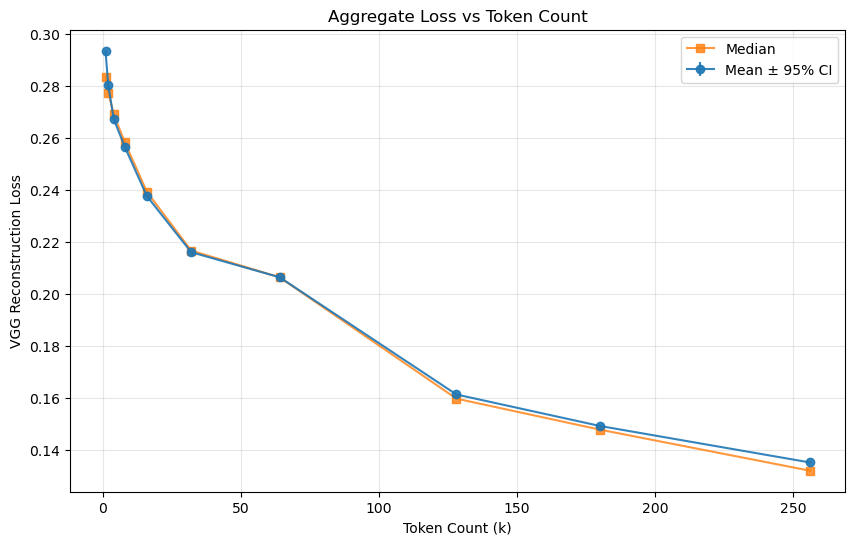

In [61]:
# Plot mean/median with error bars to see the trend clearly
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.errorbar(ks, mean_loss, yerr=ci95, fmt='-o', label='Mean ± 95% CI', alpha=0.9)
plt.plot(ks, median_loss, '-s', label='Median', alpha=0.8)
plt.title('Aggregate Loss vs Token Count')
plt.xlabel('Token Count (k)')
plt.ylabel('VGG Reconstruction Loss')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

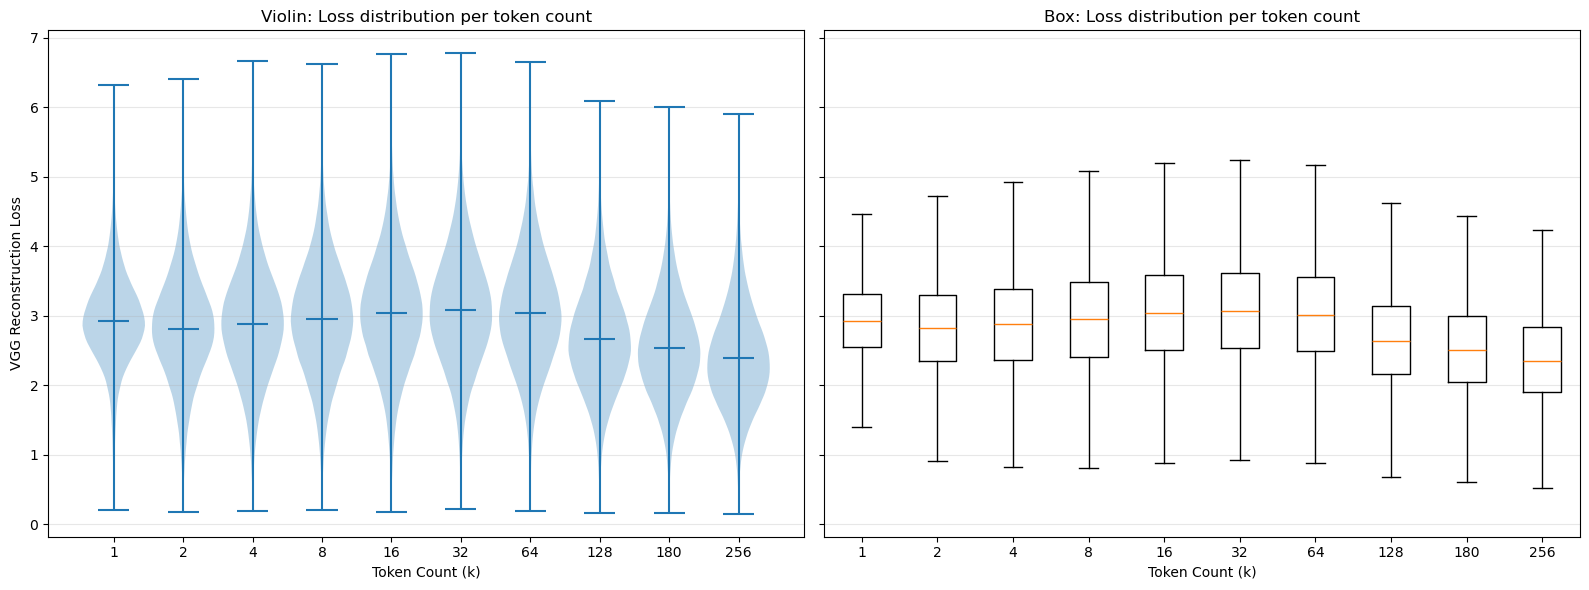

In [59]:
# Distribution per token count: violin and box plots
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

# Rebuild groupings defensively in case prior cells weren't run
try:
    _ = by_k
except NameError:
    k_vals = np.array([int(d["k_value"]) for d in data])
    loss_vals = np.array([float(d["vgg_error"]) for d in data])
    by_k = defaultdict(list)
    for k, l in zip(k_vals, loss_vals):
        by_k[int(k)].append(float(l))

ks_list = sorted(by_k.keys())
loss_groups = [by_k[k] for k in ks_list]

# Optionally limit to specific k values (uncomment to focus)
# focus_ks = [1, 2, 4, 8, 16, 32, 64, 128, 180, 256]
# ks_list, loss_groups = zip(*[(k, by_k[k]) for k in ks_list if k in focus_ks])

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Violin plot
parts = axes[0].violinplot(loss_groups, positions=np.arange(len(ks_list)), showmeans=True, showextrema=True, widths=0.9)
axes[0].set_xticks(np.arange(len(ks_list)))
axes[0].set_xticklabels(ks_list, rotation=0)
axes[0].set_title('Violin: Loss distribution per token count')
axes[0].set_xlabel('Token Count (k)')
axes[0].set_ylabel('VGG Reconstruction Loss')
axes[0].grid(True, axis='y', alpha=0.3)

# Box plot (without outliers for readability)
axes[1].boxplot(loss_groups, positions=np.arange(len(ks_list)), showfliers=False)
axes[1].set_xticks(np.arange(len(ks_list)))
axes[1].set_xticklabels(ks_list, rotation=0)
axes[1].set_title('Box: Loss distribution per token count')
axes[1].set_xlabel('Token Count (k)')
axes[1].grid(True, axis='y', alpha=0.3)

plt.tight_layout()
plt.show()